## Sound Source Mapping

Isabelle Brandicourt | March 15, 2025

Using Acoular to beamform in the frequency domain

#### First we need to generate test date for 3 sound sources in our environment

In [2]:
from pathlib import Path
import acoular as ac
import os
import matplotlib.pylab as plt


sfreq = 51200
duration = 1
num_samples = duration * sfreq
micgeofile = Path(ac.__file__).parent / 'xml' / 'array_64.xml'
h5savefile = Path('three_sources.h5')

m = ac.MicGeom(file=micgeofile)
n1 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=1)
n2 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=2, rms=0.7)
n3 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=3, rms=0.5)
p1 = ac.PointSource(signal=n1, mics=m, loc=(-0.1, -0.1, -0.3))
p2 = ac.PointSource(signal=n2, mics=m, loc=(0.15, 0, -0.3))
p3 = ac.PointSource(signal=n3, mics=m, loc=(0, 0.1, -0.3))
p = ac.Mixer(source=p1, sources=[p2, p3])
try:
    wh5 = ac.WriteH5(source=p, file=h5savefile)
    wh5.save()
except FileExistsError:
    print("File already exists. Overwriting...")
    os.remove(h5savefile)
    wh5.save()

In [3]:
ts = ac.TimeSamples( file="three_sources.h5" )
print( ts.num_channels, ts.num_samples, ts.sample_freq )

64 51200 51200.0


Can signal process in frequency OR time domain.
- In freq domain, time history data needs to be transformed into power spectra
- do this via a CROSS SPECTRAL MATRIX (CSM), this has a pair-matched cross spectra for all possible combinations of channels 
- do this using Welch's method with an fft

Then print the shape of the large matrix (number of frequencies x number of microphone channels x number of microphone channels)

In [4]:
ps = ac.PowerSpectra(source=ts, block_size=1024, window="Hanning" )
# 128 block size gives us 400 Hz frequency spacing... I want way finer so I increase block size to 1024 to get 50 Hz spacing
ps.fftfreq()

ps.csm.shape

[('three_sources_cache.h5', 1)]


(513, 64, 64)

Now we get the microphone positions from an xml file (one option of accessing them). Plot the microphone geometry.

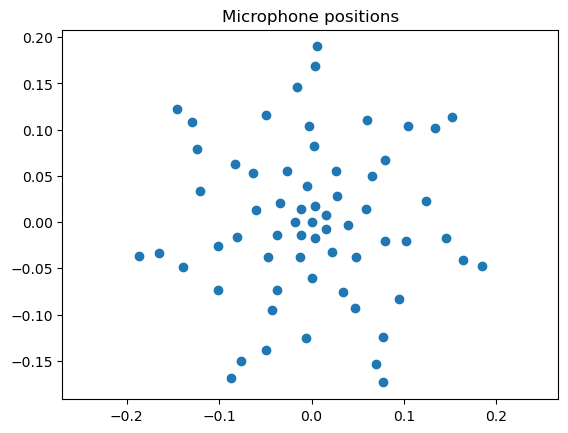

In [5]:
mg = ac.MicGeom(file=micgeofile)
mg.pos

plt.plot(mg.pos[0], mg.pos[1], 'o')
plt.axis('equal')
plt.title('Microphone positions')
plt.show()

Now we want to map the sound with a mapping grid. Define the distance (z), size, and spacing (trade off resolution for processing time naturally).

In [6]:
rg = ac.RectGrid( x_min=-0.2, x_max=0.2, y_min=-0.2, y_max=0.2, z=0.3, increment=0.01 )
rg.pos

array([[-0.2 , -0.2 , -0.2 , ...,  0.2 ,  0.2 ,  0.2 ],
       [-0.2 , -0.19, -0.18, ...,  0.18,  0.19,  0.2 ],
       [ 0.3 ,  0.3 ,  0.3 , ...,  0.3 ,  0.3 ,  0.3 ]])

#### Beamforming Bit

Use the combined hydrophones as a sound receiver with directivity "steered" to each one of the grid points. The "steering vector" connects the grid and hydrophones, taking into account environmental conditions. The standard environment here is for the air, so no flow, s.o.s. 343 m/s, and air at 20degC. 

Check the speed of sound using env.c

Then define the basic beamforming method.

In [7]:
st = ac.SteeringVector( grid=rg, mics=mg )
st.env.c

bb = ac.BeamformerBase(freq_data=ps, steer=st)

Now ask for sum of all FFT freq lines in 3rd octave band 8000 Hz. Thi sbasically adds together all the maps for those frequencies to "mimc" the result of a thrid octave filter in that band. Result = mean square sund prepssure at the center lcoation of the microphone array. 

The L_p function computes levels from mean square to sound pressure levels. 

In [8]:
pm = bb.synthetic( 8000, 3 )        # map is stored here
Lm = ac.L_p( pm )           # map in dB

[('three_sources_cache.h5', 2)]


(41, 41)
[[-350.         -350.         -350.         ... -350.
  -350.         -350.        ]
 [-350.         -350.           55.24706458 ... -350.
  -350.         -350.        ]
 [  62.14184023   62.09498459   65.71128589 ... -350.
  -350.         -350.        ]
 ...
 [-350.           54.92829777   55.24447694 ... -350.
  -350.         -350.        ]
 [  55.75544594   61.08259113   60.35912584 ...   55.91031983
    58.3532901    50.83472467]
 [  61.51732329   63.70161301   62.36943271 ...   56.38655001
    62.20756281   61.72009569]]


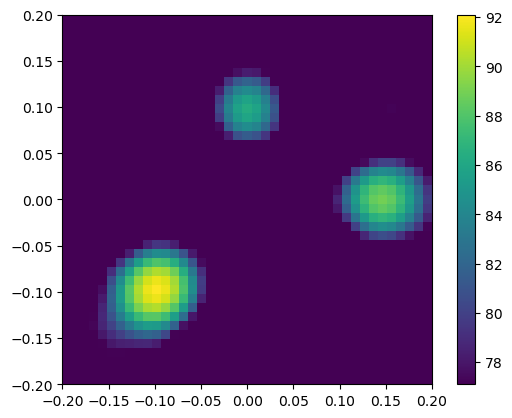

In [9]:
print(Lm.shape)
print(Lm)

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

# Shows that the sources are coming from distinct locations and have different strengths.

#### Diagonal Removal

That was a variant of beamforming that applies "diagonal removal techhnique." Basically in comparing all possible combinations of phones, there forms a diagonal line where each phone is compared to itself. We removed this before and it got rid of some artifacts. However, to not default to ignoring it, we can set r_diag to False. This allows us to see the artifacts from that calculation as well.

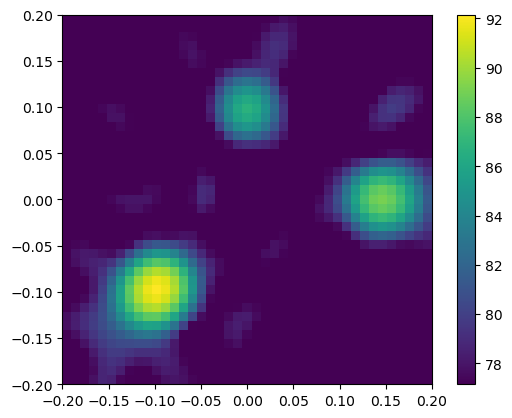

In [10]:
bb.r_diag = False

Lm = ac.L_p( bb.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

#### Functional Beamforming

Use a different beamformer instead of the standard one! 

[('three_sources_cache.h5', 3)]


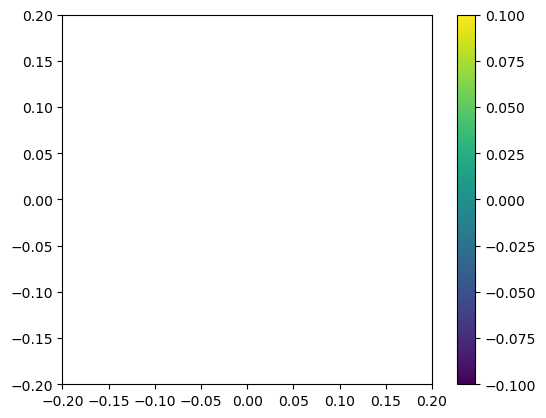

In [11]:
bf = ac.BeamformerFunctional(freq_data=ps, steer=st, gamma=50)
Lm = ac.L_p( bf.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

#### Deconvolution

Removes blur and artifacts from the result. Basically reversing the original convolution of the point spread function of this algorithm with the ideal image. 

[('three_sources_cache.h5', 4)]


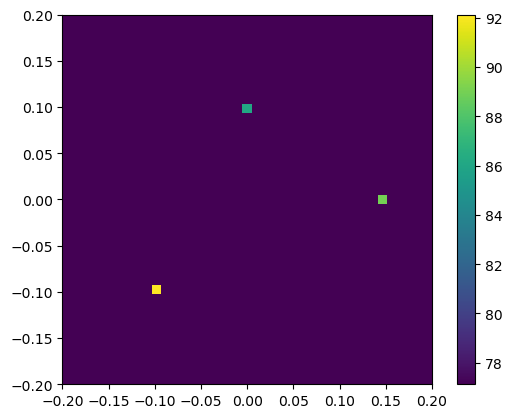

In [12]:
ts.file="three_sources.h5"
bs = ac.BeamformerCleansc( freq_data=ps, steer=st )
Lm = ac.L_p( bs.synthetic( 8000, 3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();